#1 데이터 다운로드

## 1-1 Kaggle API 활용 

A. Kaggle API를 활용해서 데이터를 다운받기 위해선 우선 토큰을 다운받아 코랩에 업로드 해야 함 
B. Kaggle 사이트에 로그인한 뒤 Account에 접속 

C. Create New API Token 으로 Token 다운로드 
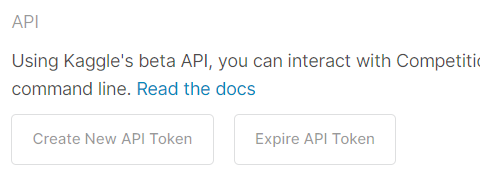

D. 다운받은 Token(이름 : kaggle.json)을 Colab에 바로 업로드 


In [ ]:
#업로드한 kaggle.json(Token 파일)을 내부 디렉토리로 이동 
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

데이터 다운로드 

In [ ]:
!kaggle datasets download -d deadskull7/fer2013

 89% 86.0M/96.6M [00:00<00:00, 151MB/s]
100% 96.6M/96.6M [00:00<00:00, 147MB/s]


## 1-2 구글드라이브 활용 

1. 아래 kaggle 링크에 접속 해서 직접 데이터 다운로드 
2. 다운로드한 데이터를 Google Drive의 tmp(미리 생성한)폴더에 업로드 
3. Colab에 구글드라이브를 연동한 뒤 복사 및 압축 해제 

In [ ]:
#구글드라이브 연동 
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp '/content/drive/MyDrive/tmp/28577_36420_compressed_fer2013.csv.zip' ./

## 1-3 압축 해제 

In [ ]:
!unzip fer2013.zip

Archive:  fer2013.zip
  inflating: fer2013.csv             


# 2 데이터 확인 및 전처리

## 2-1 Emotion 데이터 

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from matplotlib.colors import ListedColormap
import seaborn as sns

import cv2

#CSV 데이터 로드 
df = pd.read_csv("fer2013.csv")
print(df.shape)
df.head()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

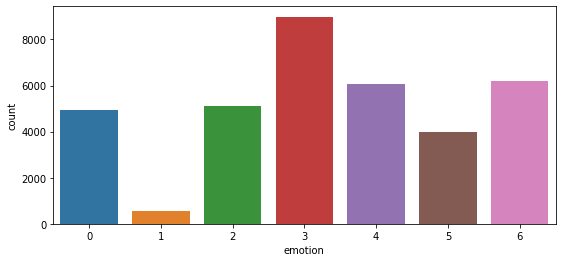

In [ ]:
#감정 별 개수 확인 - Histogram 
plt.figure(figsize=(9,4))
sns.countplot(x='emotion', data=df)
df['emotion'].value_counts()

Emotion Feature의 값은 다음을 의미 함 

    0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

1(Disgust)의 수가 매우 적으므로 0(Angry)와 통일 

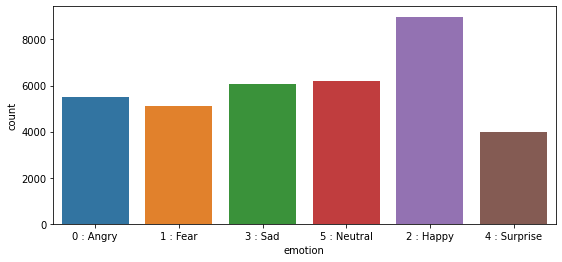

In [ ]:
df['emotion'] = df['emotion'].map( {0:0, 1:0, 2:1, 3:2, 4:3, 5:4, 6:5} ).astype(int)
category_names = {0:"Angry",1:"Fear",2:"Happy",3:"Sad",4:"Surprise",5:"Neutral"}


plt.figure(figsize=(9,4))
sns.countplot(x='emotion', data=df['emotion'].apply(lambda x: f"{x} : {category_names[x]}").reset_index())

In [ ]:
emotions = df['emotion'].values
print(emotions.shape)
print(emotions)

(35887,)
[0 0 1 ... 0 2 1]


##2-2 얼굴(이미지) 데이터 

- df(CSV) 데이터에는 이미지의 픽셀값이 저장되어 있음 
- 이를 그대로 읽어서 이미지 데이터로 변형 
- 이미지로 변형하는 과정 중에 사이즈 (48,48)로 변형 

(35887, 48, 48, 1)


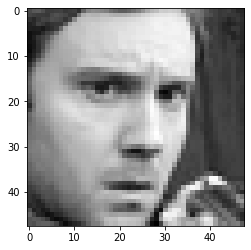

In [ ]:
image_size=(48,48)

pixels = df['pixels'].tolist()
width, height = 48, 48
faces = []

for pixel_sequence in pixels:
  face = [int(pixel) for pixel in pixel_sequence.split(' ')]
  face = np.asarray(face).reshape(width, height)
  face = cv2.resize(face.astype('uint8'),image_size)
  faces.append(face.astype('float32'))
  
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
print(faces.shape)

plt.imshow(faces[0].squeeze(), cmap="gray")

In [ ]:
#이미지 데이터 Normalization 
#Pixel 데이터의 분포를 0~255 -> 0~1로 변형 함 
print(np.min(faces), np.max(faces))
faces = faces / 255.0
print(np.min(faces), np.max(faces))

0.0 255.0
0.0 1.0


## 2-3 데이터 Split 
- Train - Test로 분할 

In [ ]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(faces, emotions, test_size=0.2)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(28709, 48, 48, 1)
(28709,)
(7178, 48, 48, 1)
(7178,)


# 3 모델 

## 3-1 모델 정의

In [ ]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPool2D, Input
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img



model = keras.Sequential()

model.add(Input(train_x.shape[1:]))
model.add(Conv2D(32, (3,3), padding="same"))
model.add(MaxPool2D())
model.add(Conv2D(64, (3,3), padding="same"))
model.add(MaxPool2D())
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])



## 3-2 데이터 증강 (Data Augmentation)

In [ ]:
train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
)

test_data_generator = ImageDataGenerator()

## 3-2 모델 학습 

In [ ]:
model.fit(
      train_data_generator.flow(train_x, train_y, 32),
      validation_data=test_data_generator.flow(test_x, test_y, 32),
      steps_per_epoch=len(train_x)/32,  
      validation_steps=len(test_x)/32,      
      epochs=10
)

# 4 평가 

In [ ]:
loss, acc = model.evaluate(
      test_data_generator.flow(test_x, test_y, 32),
      steps=len(test_x)/32
)
print(loss, acc)

224/224 [==============================] - 1s 3ms/step - loss: 1.2822 - acc: 0.5191
1.2822349071502686 0.5190861225128174


#5 결과 보기 

## 5-1 이미지 

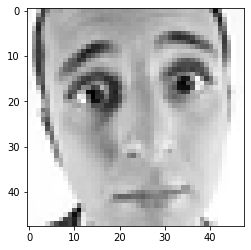

predicted category index = 4
Surprise


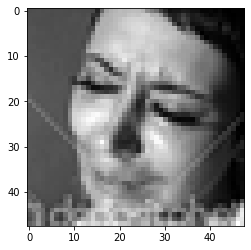

predicted category index = 3
Sad


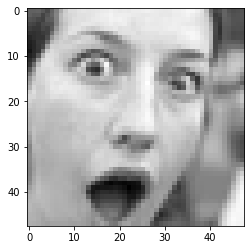

predicted category index = 4
Surprise


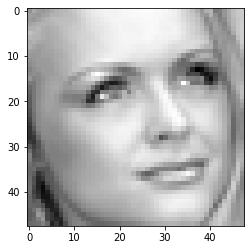

predicted category index = 2
Happy


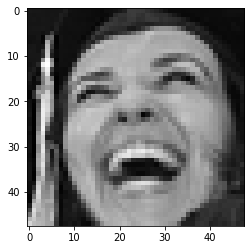

predicted category index = 2
Happy


In [ ]:
y_ = model.predict(test_x)

predicted = np.argmax(y_, axis=1)

for i in range(5):
  plt.imshow(test_x[i].squeeze(), cmap="gray")
  plt.show()
  print("predicted category index =", predicted[i])
  print(category_names[predicted[i]])


# 6 웹캠 활용 
- 웹캠으로 받은 영상을 바로 Classification model에 넣어 감정 분류 

## 6-1 함수 선언 

In [ ]:
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode

VIDEO_HTML = """
<video autoplay
 width=400 height=300></video>
<br>
<img id="output" src="https://ko.wikipedia.org/static/images/wikimedia-button.png"/>


<script>
var video = document.querySelector('video')
navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)

var canvas = document.createElement('canvas')
var [w,h] = [video.offsetWidth, video.offsetHeight]
canvas.width = w
canvas.height = h


</script>
"""

DATA_HTML = """
<script>
canvas.getContext('2d').drawImage(video, 0, 0, w, h)
var data = canvas.toDataURL('image/jpeg', %f)
</script>
"""

## 6-2 웹캠 구동 

In [ ]:
from IPython.display import Image, display
from IPython.display import clear_output
from IPython import display
from matplotlib import pyplot as plt
import cv2
import numpy as np
import base64
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

def convert_jpeg_binary_to_cv2_image(binary_image):
  return cv2.imdecode(np.fromstring(binary_image, dtype=np.uint8), -1)


def image_preprocess(image):
  image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image,dsize=(48,48))
  return image

def plot_image(img):
  plt.imshow(img,cmap = 'gray')
  plt.xlabel("X Label")
  plt.ylabel("Y Label")

  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)

  plt.grid(True)
  plt.figure(figsize=(10,7))
  plt.show()

In [ ]:
from IPython import display
from IPython.display import display

quality=1.0
display(HTML(VIDEO_HTML))


while True:
  display(HTML(DATA_HTML % quality))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  cv2_image = convert_jpeg_binary_to_cv2_image(binary)
  cv2_image = np.expand_dims(image_preprocess(cv2_image),axis=2)
  cv2_image = np.expand_dims(cv2_image,axis=0)
  y_ = model.predict(cv2_image)
  predicted = np.argmax(y_, axis=1)
  plot_image(cv2_image.squeeze())
  print(category_names[predicted[0]])
  plt.cla()  